In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

In [3]:
MIN_RECORD = 10
MAX_SEGMENT = 5

In [4]:
#function v-clustering
def v_clustering(L, threshold):
    def WAV(L1, L2):
        n = len(L)
        return (len(L1) / n) * np.var(L1) + (len(L2) / n) * np.var(L2)

    def delta_V(L, i):
        L1 = L[:i]
        L2 = L[i:]
        return np.var(L) - WAV(L1, L2)

    def find_best_split(L):
        max_delta_V = -1
        best_split_index = None

        for i in range(1, len(L)):
            delta_v = delta_V(L, i)

            if delta_v > max_delta_V:
                max_delta_V = delta_v
                best_split_index = i

        return best_split_index

    split_index = find_best_split(L)

    if split_index is None:
        return [L]

    L1 = L[:split_index]
    L2 = L[split_index:]
    if delta_V(L, split_index) < threshold :
        return [L]
    return v_clustering(L1, threshold) + v_clustering(L2, threshold)

In [5]:
def Label_cluster(current_segment, clusters, sort_term):
  result_df = pd.DataFrame(columns=['Value', 'Cluster'])
  for i, sub_array in enumerate(clusters):
      label = i + 1
      for element in sub_array:
          result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
  current_segment = current_segment.sort_values(by=[sort_term])
  if (len(current_segment) == len(result_df)):
    for i in range(len(current_segment)):
      current_segment['Cluster label'] = result_df['Cluster'].tolist()
  return current_segment

In [6]:
def cluster(SEGMENT_ID, DAY_OF_WEEK, ARRIVAL_TIME, DURATION, time_added, TRIP_ID):
  #Read data
  if SEGMENT_ID <= 15:
    data_name = "../dataset/1_Kandy_to_Digana.csv"
  else:
    data_name = "../dataset/2_Digana_to_Kandy.csv"
  input_data = pd.read_csv(data_name)
  df = input_data.copy()
  df = pd.DataFrame(df)

  #Filter by SEGMENT_ID and Day_of_week
  data = df[df['segment'] == SEGMENT_ID]
  data = data[data['day_of_week'] == DAY_OF_WEEK]

  #Reset index
  data = data.reset_index()
  data.drop(columns=["index"],inplace=True)
  current_segment = data.copy()

  #drop unnecessary columns
  data.drop(columns=["trip_id", "segment", "duration", "date", "end_time", "without_dwell_time", "avg_speed", "day_of_week"],inplace=True)

  #Normalize dataset
  for i in range(len(data)):
    string = data.loc[i, 'start_time']
    data.loc[i, 'start_time'] = float(string[0:2]) * 3600 + float(string[3:5]) * 60 + float(string[6:8])

  #Obtain array of values
  data_array=data.values

  #Specify data types
  data_array[:, 0:1] = data_array[:, 0:1].astype(float)
  data_array = data_array.tolist()

  #Transform clusters
  cluster_list = []
  for row in data_array:
    cluster_list.append(row[0])

  # Clustering for start_time
  actual_times = sorted(cluster_list)
  threshold = 100000
  clusters = v_clustering(actual_times, threshold)


  #Label clusters for original dataset
  current_segment = Label_cluster(current_segment, clusters, 'start_time')

  #Input processing
  ARRIVAL_TIME = datetime.strptime(ARRIVAL_TIME, '%H:%M:%S').time()
  seconds = (ARRIVAL_TIME.hour * 60 + ARRIVAL_TIME.minute) * 60 + ARRIVAL_TIME.second
  seconds += time_added
  #Determine belonged cluster
  center_list = []
  for element in clusters:
    center_list.append(np.mean(element))
  arr = np.array(center_list)
  difference_array = np.absolute(arr - seconds)
  index = difference_array.argmin() + 1

  #Extract trips
  trip_list = current_segment[current_segment['Cluster label'] == index]
  trip_list = trip_list['trip_id'].tolist()

  CUR_SEG = SEGMENT_ID - 1
  while (len(trip_list) >= MIN_RECORD and CUR_SEG > 0 and SEGMENT_ID - CUR_SEG < 5):
    #Filter by SEGMENT_ID and Day_of_week
    data = df[df['segment'] == CUR_SEG]
    data = data[data['day_of_week'] == DAY_OF_WEEK]
    data = data[data['trip_id'].isin(trip_list)]

    #Reset index
    data = data.reset_index()
    data.drop(columns=["index"],inplace=True)

    #drop unnecessary columns
    current_segment = data.copy()
    data.drop(columns=["trip_id", "segment", "start_time", "date", "end_time", "without_dwell_time", "avg_speed", "day_of_week"],inplace=True)

    #obtain array of values
    data_array=data.values

    #specify data types
    data_array[:, 0:1] = data_array[:, 0:1].astype(float)
    data_array = data_array.tolist()
    cluster_list = []
    for row in data_array:
      cluster_list.append(row[0])

    # Clustering for duration
    actual_times = cluster_list
    actual_times = sorted(actual_times)
    threshold = np.var(actual_times)*0.5
    clusters = v_clustering(actual_times, threshold)

    #Label clusters for original dataset
    current_segment = Label_cluster(current_segment, clusters, 'duration')

    #Passed Segment Duration
    duration = DURATION[CUR_SEG - 1]

    #Determine belonged cluster
    center_list = []
    for element in clusters:
      center_list.append(np.mean(element))
    arr = np.array(center_list)
    difference_array = np.absolute(arr - duration)
    index = difference_array.argmin() + 1

    #Extract trip
    if len(current_segment[current_segment['Cluster label'] == index]) > 1:
      trip_list = current_segment[current_segment['Cluster label'] == index]
      trip_list = trip_list['trip_id'].tolist()
    else:
      break
    CUR_SEG = CUR_SEG - 1
  data = df[df['segment'] == SEGMENT_ID]
  data = data[data['day_of_week'] == DAY_OF_WEEK]
  output = data[data['trip_id'].isin(trip_list)]
  temp_df = df[df['trip_id'] == TRIP_ID]
  real_duration = temp_df[temp_df['segment'] == SEGMENT_ID].reset_index().loc[0, 'duration']
  output = output[~output['trip_id'].isin([TRIP_ID])]
  return [real_duration, np.mean(output['duration'])]

In [7]:
def trip_prediction(TRIP_ID, SEGMENT_ID):
  #Define trip
  dataset = pd.read_csv("../dataset/1_Kandy_to_Digana.csv")
  dataset = pd.DataFrame(dataset)
  trip = dataset[dataset['trip_id'] == TRIP_ID].reset_index()
  trip
  #Input data
  DAY_OF_WEEK = trip.loc[0, 'day_of_week']
  ARRIVAL_TIME = trip.loc[SEGMENT_ID - 1, 'start_time']
  #Supposed segment duration
  DURATION = []
  for i in range(1, SEGMENT_ID):
    DURATION.append(trip.loc[i - 1, 'duration'])

  #Prediction
  error = []
  time_added = 0
  while (SEGMENT_ID <= 15):
    result = cluster(SEGMENT_ID, DAY_OF_WEEK, ARRIVAL_TIME, DURATION, time_added, TRIP_ID)
    DURATION.append(np.round(result[1], 2))
    error.append(np.round(np.absolute(result[1]- result[0]), 2))
    SEGMENT_ID = SEGMENT_ID + 1
    time_added += result[1]


  #Evaluate result
  RMSE = 0
  for i in range(len(error)):
    RMSE += error[i]**2
  RMSE = np.sqrt(RMSE/len(error))

  #Result
  print("ERROR: ", error)
  print("DURATION: ", DURATION)
  print("Trip id: ", TRIP_ID)
  print("RMSE: ", np.round(RMSE, 2))
  print("Real total duration: ",np.sum(trip['duration']))
  print("Predicted total duration: ",np.round(np.sum(DURATION),2))
  print("Different: ", np.round(np.abs(np.sum(DURATION) - np.sum(trip['duration'])),2 ))
  return [np.round(RMSE, 2), np.round(np.abs(np.sum(DURATION) - np.sum(trip['duration'])),2 ), error, DURATION]

In [8]:
df = pd.read_csv("../dataset/1_Kandy_to_Digana.csv")
RMSE_list = []
Diff_list = []
count = 0
for i in df['trip_id'].unique():
  if (count == 100):
    break
  count += 1
  result = trip_prediction(i, 10)
  RMSE_list.append(result[0])
  Diff_list.append(result[1])

/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [11.0, 220.0, 55.0, 36.0, 32.67, 127.62]
DURATION:  [69.0, 284.0, 496.0, 201.0, 97.0, 421.0, 80.0, 124.0, 57.0, 204.0, 404.0, 222.0, 175.0, 146.67, 361.62]
Trip id:  1
RMSE:  108.16
Real total duration:  2860.0
Predicted total duration:  3342.29
Different:  482.29


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [59.62, 28.83, 54.0, 26.22, 12.86, 9.43]
DURATION:  [74.0, 357.0, 436.0, 205.0, 126.0, 463.0, 100.0, 84.0, 37.0, 206.62, 258.17, 201.0, 182.78, 129.14, 314.43]
Trip id:  8
RMSE:  37.07
Real total duration:  3227.0
Predicted total duration:  3174.14
Different:  52.86


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [235.0, 10.33, 23.75, 25.8, 26.88, 15.0]
DURATION:  [88.0, 371.0, 467.0, 195.0, 152.0, 271.0, 60.0, 75.0, 57.0, 224.0, 249.33, 207.25, 163.2, 133.88, 324.0]
Trip id:  15
RMSE:  97.9
Real total duration:  3300.0
Predicted total duration:  3037.66
Different:  262.34


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [168.43, 4.0, 48.6, 19.17, 18.89, 68.0]
DURATION:  [133.0, 375.0, 473.0, 270.0, 122.0, 278.0, 49.0, 119.0, 53.0, 245.57, 193.0, 171.4, 151.83, 129.11, 350.0]
Trip id:  21
RMSE:  77.56
Real total duration:  3296.0
Predicted total duration:  3112.91
Different:  183.09


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [11.25, 51.0, 64.12, 21.62, 47.11, 68.78]
DURATION:  [101.0, 281.0, 390.0, 279.0, 177.0, 339.0, 110.0, 171.0, 58.0, 266.25, 190.0, 171.88, 165.38, 186.11, 335.78]
Trip id:  27
RMSE:  48.74
Real total duration:  3231.0
Predicted total duration:  3221.4
Different:  9.6


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [13.38, 71.71, 30.71, 86.67, 88.86, 12.67]
DURATION:  [84.0, 1123.0, 735.0, 316.0, 182.0, 373.0, 168.0, 88.0, 50.0, 202.62, 157.29, 162.29, 146.33, 193.86, 324.67]
Trip id:  32
RMSE:  60.32
Real total duration:  4407.0
Predicted total duration:  4306.06
Different:  100.94


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [43.33, 32.67, 4.33, 22.0, 29.33, 16.0]
DURATION:  [76.0, 238.0, 372.0, 155.0, 86.0, 163.0, 82.0, 60.0, 15.0, 133.33, 128.67, 131.67, 112.0, 77.67, 243.0]
Trip id:  35
RMSE:  27.58
Real total duration:  1993.0
Predicted total duration:  2073.34
Different:  80.34


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [85.88, 37.33, 5.71, 2.6, 24.25, 57.0]
DURATION:  [93.0, 399.0, 384.0, 187.0, 119.0, 319.0, 45.0, 72.0, 35.0, 203.12, 219.67, 192.29, 136.4, 139.25, 268.0]
Trip id:  38
RMSE:  45.91
Real total duration:  2862.0
Predicted total duration:  2811.73
Different:  50.27


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [109.33, 87.25, 36.5, 14.25, 9.43, 4.6]
DURATION:  [117.0, 286.0, 570.0, 280.0, 138.0, 264.0, 58.0, 67.0, 46.0, 192.67, 297.25, 213.5, 174.75, 146.43, 288.6]
Trip id:  39
RMSE:  59.46
Real total duration:  3125.0
Predicted total duration:  3139.2
Different:  14.2


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [138.67, 33.22, 7.22, 5.44, 35.67, 64.75]
DURATION:  [103.0, 212.0, 506.0, 262.0, 135.0, 283.0, 124.0, 113.0, 43.0, 310.67, 248.22, 212.22, 177.56, 152.67, 306.25]
Trip id:  49
RMSE:  65.68
Real total duration:  3044.0
Predicted total duration:  3188.59
Different:  144.59


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [28.32, 71.0, 75.67, 76.0, 50.38, 41.2]
DURATION:  [115.0, 387.0, 491.0, 194.0, 121.0, 522.0, 80.0, 96.0, 95.0, 316.68, 256.0, 223.67, 196.0, 133.38, 351.2]
Trip id:  51
RMSE:  59.97
Real total duration:  3292.0
Predicted total duration:  3577.93
Different:  285.93


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [41.0, 92.57, 59.71, 56.22, 8.67, 48.57]
DURATION:  [154.0, 267.0, 499.0, 233.0, 115.0, 508.0, 177.0, 124.0, 42.0, 244.0, 307.57, 214.71, 168.22, 122.67, 349.57]
Trip id:  52
RMSE:  56.88
Real total duration:  3301.0
Predicted total duration:  3525.74
Different:  224.74


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [63.0, 21.0, 7.5, 14.86, 9.8, 40.88]
DURATION:  [111.0, 434.0, 547.0, 351.0, 187.0, 328.0, 133.0, 131.0, 52.0, 252.0, 209.0, 193.5, 180.86, 111.2, 306.12]
Trip id:  54
RMSE:  32.8
Real total duration:  3471.0
Predicted total duration:  3526.68
Different:  55.68


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [13.0, 64.0, 53.33, 32.89, 101.12, 39.38]
DURATION:  [101.0, 340.0, 464.0, 228.0, 114.0, 214.0, 101.0, 113.0, 65.0, 253.0, 143.0, 175.67, 163.89, 207.12, 361.38]
Trip id:  62
RMSE:  57.69
Real total duration:  3001.0
Predicted total duration:  3044.06
Different:  43.06


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [63.75, 39.7, 35.0, 20.0, 6.5, 91.33]
DURATION:  [103.0, 222.0, 415.0, 244.0, 93.0, 184.0, 119.0, 72.0, 43.0, 195.75, 152.7, 170.0, 137.0, 112.5, 301.33]
Trip id:  65
RMSE:  51.07
Real total duration:  2321.0
Predicted total duration:  2564.28
Different:  243.28


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [3.75, 59.25, 39.88, 43.25, 12.75, 57.12]
DURATION:  [83.0, 175.0, 368.0, 225.0, 131.0, 283.0, 115.0, 75.0, 30.0, 168.75, 149.25, 144.88, 133.25, 102.75, 293.12]
Trip id:  67
RMSE:  41.66
Real total duration:  2261.0
Predicted total duration:  2477.0
Different:  216.0


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [94.57, 124.0, 41.88, 42.0, 95.11, 16.17]
DURATION:  [63.0, 377.0, 357.0, 211.0, 113.0, 553.0, 78.0, 111.0, 45.0, 235.57, 264.0, 230.12, 158.0, 106.89, 286.83]
Trip id:  72
RMSE:  78.68
Real total duration:  3166.0
Predicted total duration:  3189.41
Different:  23.41


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [30.14, 1.67, 17.33, 19.0, 178.86, 150.5]
DURATION:  [292.0, 214.0, 426.0, 291.0, 112.0, 197.0, 105.0, 141.0, 51.0, 298.14, 261.67, 216.67, 180.0, 134.14, 329.5]
Trip id:  80
RMSE:  96.79
Real total duration:  3583.0
Predicted total duration:  3249.12
Different:  333.88


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [90.75, 112.29, 82.75, 1.88, 28.83, 17.22]
DURATION:  [108.0, 351.0, 359.0, 238.0, 339.0, 438.0, 100.0, 110.0, 46.0, 317.75, 264.29, 232.75, 158.88, 126.83, 313.78]
Trip id:  82
RMSE:  69.31
Real total duration:  3204.0
Predicted total duration:  3503.28
Different:  299.28


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [55.0, 92.67, 65.57, 18.14, 19.0, 75.62]
DURATION:  [67.0, 296.0, 368.0, 267.0, 195.0, 389.0, 119.0, 108.0, 56.0, 282.0, 155.33, 174.43, 174.86, 119.0, 321.62]
Trip id:  91
RMSE:  60.99
Real total duration:  3119.0
Predicted total duration:  3092.24
Different:  26.76


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [94.8, 72.0, 19.14, 110.0, 4.86, 35.71]
DURATION:  [95.0, 263.0, 398.0, 207.0, 96.0, 156.0, 100.0, 75.0, 30.0, 228.8, 156.0, 153.14, 184.0, 99.14, 276.29]
Trip id:  93
RMSE:  68.24
Real total duration:  2262.0
Predicted total duration:  2517.37
Different:  255.37


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [64.0, 6.38, 4.33, 50.5, 0.17, 59.2]
DURATION:  [101.0, 351.0, 416.0, 246.0, 111.0, 355.0, 89.0, 90.0, 39.0, 276.0, 191.38, 197.33, 172.5, 124.17, 324.2]
Trip id:  98
RMSE:  41.25
Real total duration:  2899.0
Predicted total duration:  3083.58
Different:  184.58


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [67.67, 67.6, 117.5, 53.71, 16.0, 45.88]
DURATION:  [91.0, 326.0, 460.0, 225.0, 157.0, 399.0, 52.0, 114.0, 82.0, 288.67, 235.4, 223.5, 159.29, 126.0, 331.88]
Trip id:  99
RMSE:  68.56
Real total duration:  3380.0
Predicted total duration:  3270.74
Different:  109.26


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [57.0, 23.0, 45.2, 20.67, 14.83, 30.83]
DURATION:  [89.0, 313.0, 514.0, 276.0, 156.0, 378.0, 101.0, 109.0, 41.0, 222.0, 353.0, 219.2, 154.67, 122.17, 301.83]
Trip id:  101
RMSE:  35.16
Real total duration:  3234.0
Predicted total duration:  3349.87
Different:  115.87


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [173.0, 33.0, 57.0, 62.31, 27.5, 35.4]
DURATION:  [91.0, 227.0, 363.0, 228.0, 100.0, 725.0, 88.0, 75.0, 56.0, 381.0, 146.0, 209.0, 173.31, 129.5, 328.4]
Trip id:  108
RMSE:  81.81
Real total duration:  2998.0
Predicted total duration:  3320.21
Different:  322.21


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [115.29, 153.11, 63.67, 1.12, 25.0, 101.33]
DURATION:  [160.0, 330.0, 398.0, 256.0, 150.0, 214.0, 59.0, 91.0, 55.0, 241.71, 219.89, 252.67, 178.12, 126.0, 400.33]
Trip id:  111
RMSE:  92.81
Real total duration:  3259.0
Predicted total duration:  3131.72
Different:  127.28


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [57.0, 19.0, 2.62, 32.33, 23.22, 206.43]
DURATION:  [112.0, 229.0, 391.0, 209.0, 146.0, 440.0, 136.0, 142.0, 60.0, 189.0, 246.0, 184.62, 186.33, 155.22, 479.43]
Trip id:  113
RMSE:  89.27
Real total duration:  3117.0
Predicted total duration:  3305.6
Different:  188.6


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [121.73, 50.41, 25.44, 6.5, 17.3, 40.38]
DURATION:  [118.0, 342.0, 449.0, 215.0, 164.0, 620.0, 108.0, 90.0, 56.0, 303.73, 239.41, 199.56, 176.5, 171.3, 336.38]
Trip id:  115
RMSE:  57.7
Real total duration:  3391.0
Predicted total duration:  3588.88
Different:  197.88


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [36.67, 36.27, 19.87, 68.75, 147.22, 30.89]
DURATION:  [89.0, 286.0, 368.0, 227.0, 132.0, 459.0, 132.0, 92.0, 40.0, 222.67, 186.27, 166.13, 157.25, 326.78, 362.89]
Trip id:  126
RMSE:  71.19
Real total duration:  3379.0
Predicted total duration:  3246.99
Different:  132.01


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [40.33, 17.8, 35.33, 14.78, 27.5, 9.83]
DURATION:  [97.0, 316.0, 432.0, 226.0, 159.0, 242.0, 170.0, 88.0, 43.0, 166.67, 148.2, 151.67, 150.22, 108.5, 315.17]
Trip id:  127
RMSE:  26.65
Real total duration:  2959.0
Predicted total duration:  2813.43
Different:  145.57


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [29.38, 10.57, 12.0, 9.29, 14.86, 31.0]
DURATION:  [119.0, 387.0, 471.0, 254.0, 170.0, 276.0, 80.0, 93.0, 42.0, 157.62, 151.43, 162.0, 147.29, 110.86, 272.0]
Trip id:  130
RMSE:  19.95
Real total duration:  2890.0
Predicted total duration:  2893.2
Different:  3.2


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [31.33, 2.29, 1.14, 5.5, 5.75, 21.63]
DURATION:  [82.0, 280.0, 430.0, 205.0, 125.0, 417.0, 69.0, 105.0, 46.0, 237.33, 206.71, 181.14, 165.5, 119.25, 302.63]
Trip id:  135
RMSE:  15.91
Real total duration:  2920.0
Predicted total duration:  2971.56
Different:  51.56


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [111.83, 116.0, 54.0, 18.67, 22.0, 31.83]
DURATION:  [70.0, 282.0, 437.0, 274.0, 128.0, 315.0, 111.0, 115.0, 51.0, 296.83, 247.0, 181.0, 131.33, 101.0, 279.17]
Trip id:  140
RMSE:  71.56
Real total duration:  3106.0
Predicted total duration:  3019.33
Different:  86.67


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [27.88, 24.71, 24.33, 18.0, 175.67, 2.86]
DURATION:  [109.0, 269.0, 386.0, 241.0, 120.0, 510.0, 80.0, 119.0, 47.0, 224.88, 194.71, 183.33, 196.0, 123.33, 322.14]
Trip id:  143
RMSE:  74.35
Real total duration:  3209.0
Predicted total duration:  3125.39
Different:  83.61


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [138.6, 62.25, 30.6, 18.0, 33.5, 9.2]
DURATION:  [95.0, 283.0, 415.0, 228.0, 154.0, 345.0, 85.0, 111.0, 40.0, 219.4, 324.25, 197.4, 181.0, 155.5, 306.2]
Trip id:  147
RMSE:  65.26
Real total duration:  3186.0
Predicted total duration:  3139.75
Different:  46.25


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [86.71, 64.83, 185.86, 44.29, 58.75, 51.78]
DURATION:  [82.0, 215.0, 425.0, 243.0, 163.0, 400.0, 130.0, 89.0, 52.0, 304.71, 227.83, 220.14, 146.71, 130.25, 325.78]
Trip id:  151
RMSE:  95.18
Real total duration:  3240.0
Predicted total duration:  3154.42
Different:  85.58


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [137.33, 32.89, 50.62, 46.0, 19.5, 196.5]
DURATION:  [109.0, 269.0, 398.0, 251.0, 164.0, 417.0, 79.0, 104.0, 50.0, 247.67, 212.11, 190.38, 144.0, 103.5, 470.5]
Trip id:  153
RMSE:  102.97
Real total duration:  3299.0
Predicted total duration:  3209.16
Different:  89.84


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [65.25, 87.25, 98.43, 32.67, 53.67, 53.4]
DURATION:  [95.0, 515.0, 503.0, 300.0, 142.0, 488.0, 165.0, 121.0, 44.0, 180.75, 202.75, 184.57, 198.33, 158.33, 370.4]
Trip id:  158
RMSE:  68.75
Real total duration:  3952.0
Predicted total duration:  3668.13
Different:  283.87


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [19.0, 95.5, 15.9, 24.5, 106.0, 61.0]
DURATION:  [70.0, 346.0, 585.0, 229.0, 166.0, 235.0, 126.0, 105.0, 80.0, 214.0, 159.5, 165.9, 151.5, 158.0, 340.0]
Trip id:  164
RMSE:  64.92
Real total duration:  3372.0
Predicted total duration:  3130.9
Different:  241.1


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [13.12, 16.86, 44.75, 20.67, 13.71, 42.71]
DURATION:  [81.0, 294.0, 446.0, 353.0, 148.0, 225.0, 69.0, 105.0, 45.0, 199.12, 154.14, 144.25, 142.33, 108.71, 299.29]
Trip id:  166
RMSE:  28.57
Real total duration:  2912.0
Predicted total duration:  2813.84
Different:  98.16


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [8.5, 292.0, 23.33, 14.0, 22.67, 20.33]
DURATION:  [91.0, 265.0, 355.0, 209.0, 106.0, 173.0, 52.0, 45.0, 33.0, 133.5, 417.0, 143.33, 124.0, 105.67, 232.67]
Trip id:  167
RMSE:  120.42
Real total duration:  2162.0
Predicted total duration:  2485.17
Different:  323.17


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [76.75, 46.0, 3.33, 5.6, 11.0, 94.4]
DURATION:  [86.0, 288.0, 421.0, 256.0, 101.0, 401.0, 80.0, 111.0, 52.0, 202.25, 224.0, 199.33, 155.4, 123.0, 312.4]
Trip id:  169
RMSE:  53.36
Real total duration:  3054.0
Predicted total duration:  3012.38
Different:  41.62


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [143.0, 79.14, 2.0, 85.0, 12.67, 69.25]
DURATION:  [132.0, 247.0, 401.0, 293.0, 151.0, 254.0, 51.0, 67.0, 45.0, 294.0, 266.86, 185.0, 162.0, 128.67, 326.75]
Trip id:  174
RMSE:  80.52
Real total duration:  3370.0
Predicted total duration:  3004.28
Different:  365.72


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [3.33, 56.33, 8.6, 20.0, 35.0, 25.5]
DURATION:  [90.0, 319.0, 469.0, 229.0, 134.0, 336.0, 99.0, 139.0, 41.0, 272.67, 295.33, 231.4, 174.0, 140.0, 329.5]
Trip id:  175
RMSE:  30.37
Real total duration:  3295.0
Predicted total duration:  3298.9
Different:  3.9


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [157.0, 65.57, 2.0, 30.4, 9.0, 217.75]
DURATION:  [100.0, 234.0, 351.0, 203.0, 152.0, 251.0, 53.0, 96.0, 51.0, 258.0, 263.43, 206.0, 176.4, 135.0, 525.75]
Trip id:  180
RMSE:  113.56
Real total duration:  3041.0
Predicted total duration:  3055.58
Different:  14.58


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [3.5, 56.5, 93.14, 19.5, 27.89, 7.12]
DURATION:  [120.0, 241.0, 326.0, 202.0, 130.0, 654.0, 114.0, 217.0, 55.0, 202.5, 150.5, 158.86, 131.5, 118.11, 283.12]
Trip id:  181
RMSE:  46.71
Real total duration:  3290.0
Predicted total duration:  3103.59
Different:  186.41


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [23.0, 11.0, 28.5, 13.5, 29.4, 68.2]
DURATION:  [104.0, 280.0, 383.0, 243.0, 137.0, 298.0, 83.0, 80.0, 48.0, 171.0, 154.0, 154.5, 138.5, 91.6, 299.8]
Trip id:  188
RMSE:  34.54
Real total duration:  2839.0
Predicted total duration:  2665.4
Different:  173.6


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [137.33, 61.0, 7.0, 9.83, 27.14, 32.12]
DURATION:  [95.0, 250.0, 502.0, 229.0, 135.0, 356.0, 69.0, 73.0, 37.0, 199.67, 189.0, 177.0, 144.17, 115.86, 314.12]
Trip id:  191
RMSE:  63.89
Real total duration:  3082.0
Predicted total duration:  2885.82
Different:  196.18


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [32.59, 75.33, 81.12, 126.57, 30.62, 21.12]
DURATION:  [104.0, 270.0, 390.0, 165.0, 103.0, 381.0, 68.0, 76.0, 39.0, 234.59, 237.33, 199.12, 246.57, 132.62, 280.12]
Trip id:  193
RMSE:  71.56
Real total duration:  2559.0
Predicted total duration:  2926.35
Different:  367.35


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [460.2, 4.0, 68.29, 12.43, 4.0, 48.86]
DURATION:  [83.0, 324.0, 413.0, 202.0, 114.0, 454.0, 69.0, 89.0, 44.0, 214.8, 178.0, 184.71, 164.57, 105.0, 296.86]
Trip id:  195
RMSE:  191.06
Real total duration:  3428.0
Predicted total duration:  2935.94
Different:  492.06


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [165.8, 1.2, 0.33, 20.43, 13.0, 56.25]
DURATION:  [62.0, 305.0, 414.0, 175.0, 120.0, 510.0, 105.0, 108.0, 53.0, 222.2, 201.2, 223.67, 147.57, 129.0, 299.25]
Trip id:  196
RMSE:  72.16
Real total duration:  3217.0
Predicted total duration:  3074.89
Different:  142.11


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [156.87, 56.0, 14.12, 97.0, 72.67, 12.33]
DURATION:  [48.0, 238.0, 567.0, 203.0, 167.0, 203.0, 95.0, 66.0, 86.0, 266.13, 225.0, 182.12, 144.0, 134.33, 337.67]
Trip id:  198
RMSE:  84.44
Real total duration:  3231.0
Predicted total duration:  2962.25
Different:  268.75


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [295.67, 70.0, 78.86, 67.0, 40.44, 70.88]
DURATION:  [83.0, 349.0, 654.0, 197.0, 102.0, 230.0, 78.0, 108.0, 33.0, 192.33, 217.0, 270.86, 210.0, 136.44, 367.88]
Trip id:  204
RMSE:  135.21
Real total duration:  3197.0
Predicted total duration:  3228.51
Different:  31.51


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [4.18, 36.33, 40.0, 15.0, 52.88, 96.67]
DURATION:  [103.0, 320.0, 663.0, 175.0, 134.0, 298.0, 74.0, 227.0, 35.0, 257.82, 271.33, 168.0, 155.0, 147.12, 383.67]
Trip id:  206
RMSE:  50.5
Real total duration:  3391.0
Predicted total duration:  3411.94
Different:  20.94


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [63.29, 27.67, 35.71, 8.86, 11.11, 60.25]
DURATION:  [119.0, 328.0, 502.0, 239.0, 151.0, 416.0, 67.0, 170.0, 60.0, 272.29, 207.33, 208.29, 175.86, 110.89, 332.25]
Trip id:  207
RMSE:  40.58
Real total duration:  3301.0
Predicted total duration:  3358.91
Different:  57.91


/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({'Value': [element], 'Cluster': [label]})], ignore_index=True)
/tmp/ipykernel_5661/1480359928.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA e

ERROR:  [111.5, 91.25, 26.86, 59.14, 28.0, 92.0]
DURATION:  [91.0, 410.0, 442.0, 341.0, 200.0, 340.0, 99.0, 114.0, 55.0, 247.5, 196.25, 187.86, 191.14, 120.0, 334.0]
Trip id:  209
RMSE:  75.53
Real total duration:  2960.0
Predicted total duration:  3368.75
Different:  408.75


KeyboardInterrupt: 

In [ ]:
x = []
count = 0
for i in df['trip_id'].unique():
  if (count == 100):
    break
  count += 1
  x.append(i)

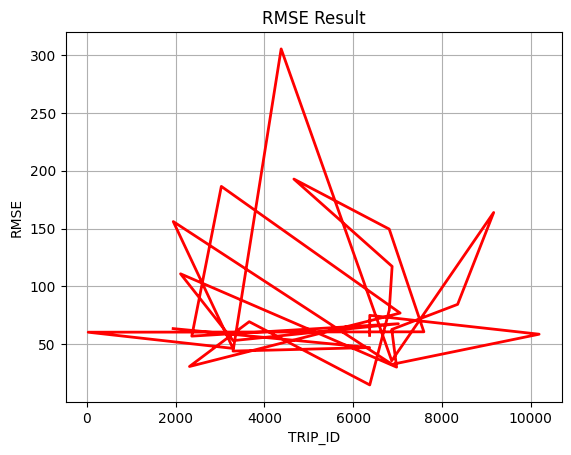

Average RMSE: 86.31


In [ ]:
plt.plot(x, RMSE_list, color='red', linewidth=2)
plt.xlabel('TRIP_ID')
plt.ylabel('RMSE')
plt.title('RMSE Result')

# Add the grid
plt.grid(True)

# Show the plot
plt.show()
print("Average RMSE:", np.round(np.mean(RMSE_list),2))

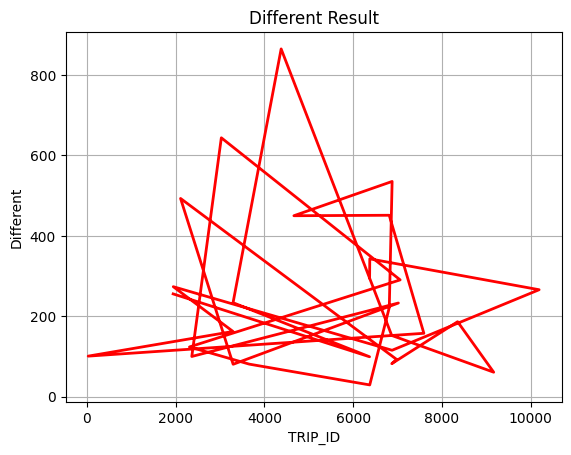

Average Different: 249.15


In [ ]:
plt.plot(x, Diff_list, color='red', linewidth=2)
plt.xlabel('TRIP_ID')
plt.ylabel('Different')
plt.title('Different Result')

# Add the grid
plt.grid(True)

# Show the plot
plt.show()
print("Average Different:", np.round(np.mean(Diff_list),2))

In [ ]:
from google.colab import files
filename = "seg10_dir1_100trip.csv"
df = pd.DataFrame(list(zip(x, RMSE_list, Diff_list)),
               columns =['TRIP_ID', 'RMSE', 'DIFFERENT'])
df.to_csv(filename, encoding = 'utf-8-sig')
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
result = trip_prediction(32 ,1)

ERROR:  [19.45, 791.67, 292.0, 60.2, 29.5, 77.5, 68.57, 0.56, 1.0, 6.0, 60.12, 38.33, 52.22, 177.0, 18.6]
DURATION:  [103.45, 331.33, 443.0, 255.8, 152.5, 295.5, 99.43, 88.56, 51.0, 210.0, 168.88, 154.67, 180.78, 282.0, 330.6]
Trip id:  32
RMSE:  226.14
Real total duration:  4407.0
Predicted total duration:  3147.5
Different:  1259.5


In [ ]:
dataset = pd.read_csv("../dataset/1_Kandy_to_Digana.csv")
dataset = pd.DataFrame(dataset)
trip = dataset[dataset['trip_id'] == 181].reset_index()
trip['prediction'] = result[3]
trip['error'] = result[2]
trip

,index,trip_id,segment,date,start_time,end_time,without_dwell_time,avg_speed,duration,day_of_week,prediction,error
0,675,181,1,2021-10-06,13:51:02,13:53:02,120.0,5.217500,120.0,2,134.53,14.53
1,676,181,2,2021-10-06,13:53:02,13:57:03,165.0,7.762424,241.0,2,451.43,210.43
2,677,181,3,2021-10-06,13:57:03,14:02:29,326.0,6.480061,326.0,2,976.00,650.00
3,678,181,4,2021-10-06,14:02:29,14:05:51,202.0,7.679703,202.0,2,246.86,44.86
4,679,181,5,2021-10-06,14:05:51,14:08:01,130.0,6.500000,130.0,2,137.12,7.12
5,680,181,6,2021-10-06,14:08:01,14:18:55,253.0,5.187747,654.0,2,259.40,394.60
6,681,181,7,2021-10-06,14:18:55,14:20:49,59.0,6.293220,114.0,2,89.67,24.33
7,682,181,8,2021-10-06,14:20:49,14:24:26,195.0,3.202564,217.0,2,85.91,131.09
8,683,181,9,2021-10-06,14:24:26,14:25:21,55.0,4.676364,55.0,2,47.50,7.50
9,684,181,10,2021-10-06,14:25:21,14:28:40,163.0,7.576074,199.0,2,292.25,93.25


In [ ]:
df = pd.read_csv("seg1_dir1_100trip.csv")
df = pd.DataFrame(df)
df = df[['TRIP_ID', 'DIFFERENT']]
df = df[df['DIFFERENT'] < 10]
low_dif_trip = df['TRIP_ID'].tolist()


df = pd.read_csv("seg10_dir1_100trip.csv")
df = pd.DataFrame(df)
df = df[['TRIP_ID', 'DIFFERENT']]
df = df[df['DIFFERENT'] < 10]
low_dif_trip.append(df['TRIP_ID'].tolist())
print(low_dif_trip)

[207, 312, [27, 130, 175, 305]]


In [ ]:
result = trip_prediction(312 , 1)

ERROR:  [37.76, 15.81, 13.0, 1.0, 1.4, 307.5, 34.67, 12.33, 13.67, 115.11, 138.0, 100.6, 10.0, 23.62, 40.89]
DURATION:  [106.76, 266.81, 417.0, 219.0, 126.6, 585.5, 70.33, 90.67, 41.33, 206.89, 228.0, 149.4, 147.0, 110.62, 280.89]
Trip id:  312
RMSE:  97.53
Real total duration:  3039.0
Predicted total duration:  3046.8
Different:  7.8


In [ ]:
dataset = pd.read_csv("../dataset/1_Kandy_to_Digana.csv")
dataset = pd.DataFrame(dataset)
trip = dataset[dataset['trip_id'] == 312].reset_index()
trip['prediction'] = result[3]
trip['error'] = result[2]
trip = trip[['trip_id', 'segment', 'duration', 'prediction', 'error']]
trip

,trip_id,segment,duration,prediction,error
0,312,1,69.0,106.76,37.76
1,312,2,251.0,266.81,15.81
2,312,3,430.0,417.00,13.00
3,312,4,218.0,219.00,1.00
4,312,5,128.0,126.60,1.40
5,312,6,278.0,585.50,307.50
6,312,7,105.0,70.33,34.67
7,312,8,103.0,90.67,12.33
8,312,9,55.0,41.33,13.67
9,312,10,322.0,206.89,115.11


In [ ]:
df = pd.read_csv("bus_trips_654.csv")
df = pd.DataFrame(df)
df = df[(df['direction'] == 1) & (df['duration_in_mins'] > 70)]
df = df.sort_values(by='duration_in_mins', ascending=False)
long_trip = df['trip_id'].tolist()
df = pd.read_csv("../dataset/1_Kandy_to_Digana.csv")
df = pd.DataFrame(df)
RMSE_list = []
Diff_list = []
x = []
for i in long_trip:
    if (i in df['trip_id'].unique()):
      result = trip_prediction(i, 10)
      x.append(i)
      RMSE_list.append(result[0])
      Diff_list.append(result[1])

ERROR:  [12.5, 86.11, 67.71, 73.0, 8.25, 48.0]
DURATION:  [127.0, 595.0, 1356.0, 446.0, 150.0, 257.0, 79.0, 101.0, 42.0, 201.5, 214.89, 176.29, 125.0, 117.75, 284.0]
Trip id:  6369
RMSE:  57.53
Real total duration:  4568.0
Predicted total duration:  4272.43
Different:  295.57
ERROR:  [3.27, 73.25, 4.0, 47.71, 86.25, 136.22]
DURATION:  [74.0, 966.0, 896.0, 349.0, 165.0, 352.0, 44.0, 92.0, 41.0, 189.73, 271.75, 214.0, 159.29, 97.75, 326.78]
Trip id:  6373
RMSE:  74.9
Real total duration:  4581.0
Predicted total duration:  4238.3
Different:  342.7
ERROR:  [40.5, 81.12, 41.86, 29.86, 23.25, 95.89]
DURATION:  [81.0, 416.0, 887.0, 1187.0, 358.0, 226.0, 130.0, 98.0, 42.0, 221.5, 257.12, 189.86, 158.86, 106.75, 422.89]
Trip id:  10186
RMSE:  58.59
Real total duration:  4516.0
Predicted total duration:  4781.98
Different:  265.98
ERROR:  [24.86, 31.0, 54.12, 6.25, 41.71, 7.29]
DURATION:  [200.0, 794.0, 1350.0, 484.0, 153.0, 197.0, 81.0, 94.0, 42.0, 205.14, 214.0, 216.12, 182.25, 138.71, 308.29]

In [ ]:
trip_prediction(31, 1)

KeyError: ignored